In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver();
    tf.config.experimental_connect_to_cluster(tpu);
    tf.tpu.experimental.initialize_tpu_system(tpu);
    strategy = tf.distribute.TPUStrategy(tpu);
    BATCH_SIZE = strategy.num_replicas_in_sync * 4;
    print("Running on TPU:", tpu.master())
    print(f"Batch Size good: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync;
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")  

Running on 1 replicas
Batch Size: 32


In [3]:
train1=pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
train2=pd.read_csv("/kaggle/input/llm-detect-ai-generated-text-deobfuscation/train_from_LLM-Detect_AI-GT_1MNB-3SGD.csv")

train2 = train2.drop(['id','prompt_id'], axis=1)

In [4]:
print(train1.head())
print(train1.shape)

                                                text  label  \
0  Phones\n\nModern humans today are always on th...      0   
1  This essay will explain if drivers should or s...      0   
2  Driving while the use of cellular devices\n\nT...      0   
3  Phones & Driving\n\nDrivers should not be able...      0   
4  Cell Phone Operation While Driving\n\nThe abil...      0   

          prompt_name           source  RDizzl3_seven  
0  Phones and driving  persuade_corpus          False  
1  Phones and driving  persuade_corpus          False  
2  Phones and driving  persuade_corpus          False  
3  Phones and driving  persuade_corpus          False  
4  Phones and driving  persuade_corpus          False  
(44868, 5)


In [5]:
print(train2.head())
print(train2.shape)

                                                text  label  \
0  PhonesModern humans today are always on their ...      0   
1  This essay will explain if drivers should or s...      0   
2  Driving while the use of cellular devicesToday...      0   
3  Phones & DrivingDrivers should not be able to ...      0   
4  Cell Phone Operation While DrivingThe ability ...      0   

          prompt_name           source RDizzl3_seven  
0  Phones and driving  persuade_corpus         False  
1  Phones and driving  persuade_corpus         False  
2  Phones and driving  persuade_corpus         False  
3  Phones and driving  persuade_corpus         False  
4  Phones and driving  persuade_corpus         False  
(46246, 5)


In [6]:
train = pd.concat([train1, train2])

train

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
46241,There has been a fuss about the Elector Colleg...,0,NaN,NaN,NaN
46242,Limiting car usage has many advantages. Such a...,0,NaN,NaN,NaN
46243,There's a new trend that has been developing f...,0,NaN,NaN,NaN
46244,As we all know cars are a big part of our soci...,0,NaN,NaN,NaN


In [7]:
train

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
46241,There has been a fuss about the Elector Colleg...,0,NaN,NaN,NaN
46242,Limiting car usage has many advantages. Such a...,0,NaN,NaN,NaN
46243,There's a new trend that has been developing f...,0,NaN,NaN,NaN
46244,As we all know cars are a big part of our soci...,0,NaN,NaN,NaN


In [8]:
import re

def clean_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove newline
    text = re.sub(r'\n', ' ', text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #remove multiple consecutive blank spaces 
    text = re.sub(r'\s+', ' ', text)
        
    return text

In [9]:
train['text'] = train['text'].apply(clean_text)

In [10]:
len(max(train['text'], key=len))

9058

In [11]:

!pip install transformers
from transformers import DistilBertTokenizerFast

In [12]:
MODEL_CHECKPOINT = "distilbert-base-uncased" #uso il distilled per migliorare i tempi di encoding ...

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_CHECKPOINT)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [13]:
MAX_LENGTH = 512

def encode_text(text, tokenizer):
    encoded = tokenizer.batch_encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LENGTH, 
        padding='max_length',
        truncation=True,
        return_attention_mask=False,
        return_tensors="tf",
    )
    
    return np.array(encoded["input_ids"], dtype="int32")

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train['text'], train['label'], test_size=0.2, random_state=42)

In [15]:
Xe_train = encode_text(X_train.tolist(),tokenizer)
Xe_test = encode_text(X_test.tolist(),tokenizer)

In [16]:
Xe_train

array([[  101,  2469,  1045, ...,     0,     0,     0],
       [  101,  6203,  4054, ...,     0,     0,     0],
       [  101,  1999, 10561, ...,     0,     0,     0],
       ...,
       [  101,  4931,  2061, ...,     0,     0,     0],
       [  101,  3793,  2075, ...,     0,     0,     0],
       [  101,  6203,  4054, ...,     0,     0,     0]], dtype=int32)

Dato che è computazionalmente difficile convertire tutto il dataset in embeddings, inserisco un layer custom di Keras che serve a questo! Iniziamo a creare il modello!

In [19]:
import keras

def CNN_model(input_dim):
    input_ids = tf.keras.Input(shape=(MAX_LENGTH,), name='tokenized_dataset', dtype='int32')
    emb1 = keras.layers.Embedding(input_dim,256, input_length=MAX_LENGTH, name="embeddings")(input_ids)
    reshape = keras.layers.Reshape(( MAX_LENGTH, 256,1))(emb1)
    conv1 = keras.layers.Conv2D(128, 3, activation='leaky_relu', name="convolution-1")(reshape)
    drp1 = keras.layers.Dropout(0.50)(conv1)
    conv2 = keras.layers.Conv2D(64, 3, activation='leaky_relu', name="convolution-2")(drp1)
    maxpool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same", name="maxpool1") (conv2)
    conv3 = keras.layers.Conv2D(32, 3, activation='leaky_relu', name="convolution-3")(maxpool1)
    maxpool2 = keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same", name="maxpool2") (conv3)
    maxpool3 = keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same", name="maxpool3") (maxpool2)
    
    flat = keras.layers.Flatten()(maxpool3)
    dense1 = keras.layers.Dense(128,activation="leaky_relu", kernel_regularizer='l1_l2')(flat)
    drp1 = keras.layers.Dropout(0.45)(dense1)
    dense2 = keras.layers.Dense(64,activation="leaky_relu")(drp1)
    dense3 = keras.layers.Dense(16,activation="leaky_relu")(dense2)
    out = keras.layers.Dense(1,activation="sigmoid")(dense3)
    
    model = tf.keras.Model(inputs=input_ids, outputs=out, name="CNN_Model")
    return model

In [20]:
learning_rate = 0.001
with strategy.scope():

    cnn = CNN_model(8192)
    
    cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                              loss=tf.keras.losses.BinaryCrossentropy(),
                              metrics=[tf.keras.metrics.BinaryAccuracy()])
    cnn.summary()

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tokenized_dataset (InputLa  [(None, 512)]             0         
 yer)                                                            
                                                                 
 embeddings (Embedding)      (None, 512, 256)          2097152   
                                                                 
 reshape (Reshape)           (None, 512, 256, 1)       0         
                                                                 
 convolution-1 (Conv2D)      (None, 510, 254, 128)     1280      
                                                                 
 dropout (Dropout)           (None, 510, 254, 128)     0         
                                                                 
 convolution-2 (Conv2D)      (None, 508, 252, 64)      73792     
                                                         

In [21]:
history = cnn.fit(
    np.asarray(Xe_train),
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=3,
    validation_data=(
        np.asarray(Xe_test),
        Y_test,
    ),
)

Epoch 1/3


2024-01-16 16:00:20.808665: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inCNN_Model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2278/2278 [==============================] - 1179s 513ms/step - loss: 10.9366 - binary_accuracy: 0.9313 - val_loss: 9.7639 - val_binary_accuracy: 0.9868
Epoch 2/3
2278/2278 [==============================] - 1161s 510ms/step - loss: 9.8228 - binary_accuracy: 0.9886 - val_loss: 9.7081 - val_binary_accuracy: 0.9877
Epoch 3/3
2278/2278 [==============================] - 1162s 510ms/step - loss: 9.7136 - binary_accuracy: 0.9924 - val_loss: 9.4320 - val_binary_accuracy: 0.9929


In [22]:
cnn.save("cnn_3conv_regularizers.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_test, y_pred):
    y_pred_class = np.where(y_pred > 0.5, 1, 0)  
    cm = confusion_matrix(y_test, y_pred_class)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [26]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

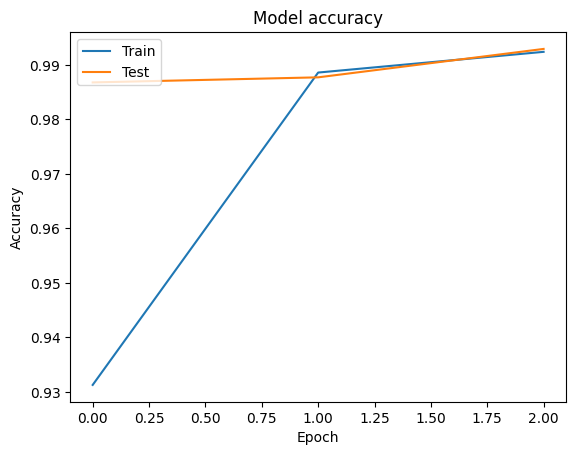

In [27]:
plot_accuracy(history)

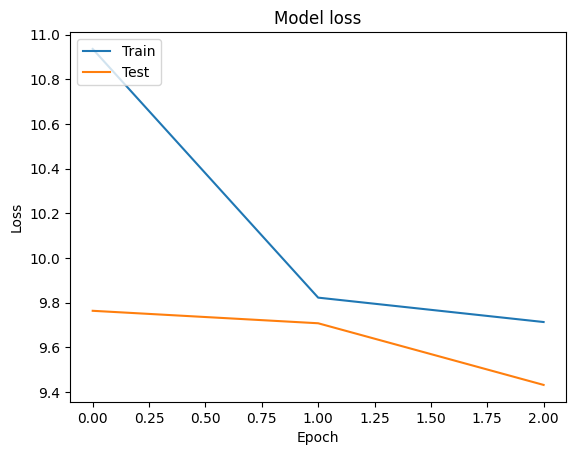

In [28]:
plot_loss(history)

570/570 [==============================] - 47s 82ms/step


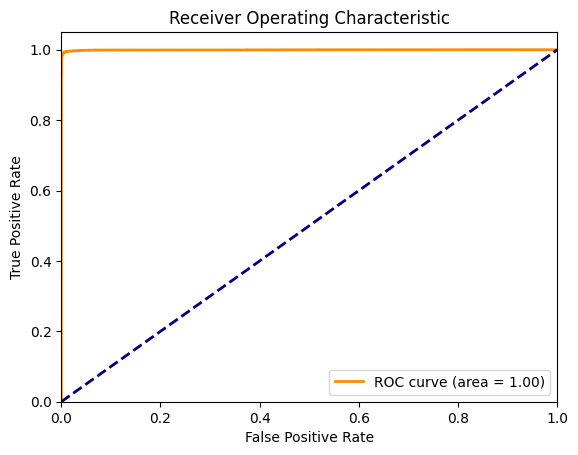

In [33]:
y_pred = cnn.predict(np.asarray(Xe_test))
plot_roc(Y_test, y_pred)

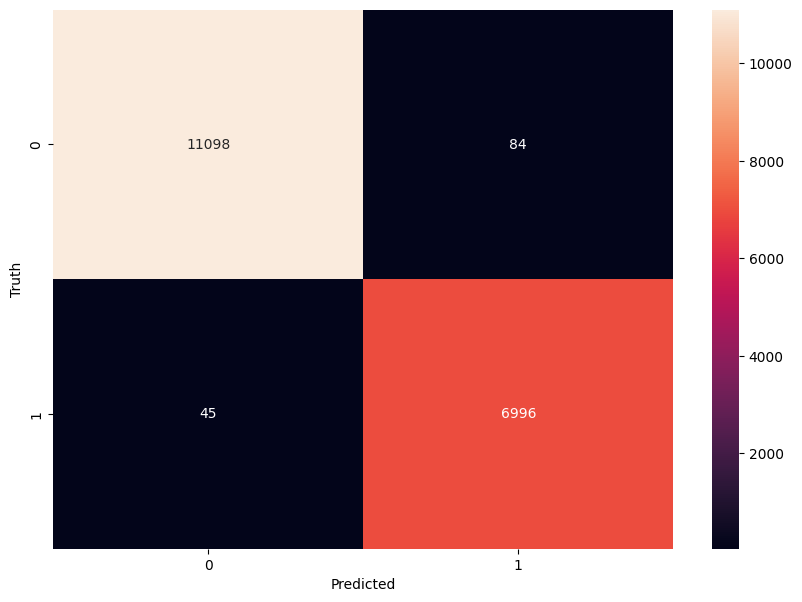

In [63]:
plot_confusion_matrix(Y_test, y_pred)

![important](https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcTEiUz1P0WO08_yym9JNvzQwj4VQGjFY9vKQiEsnVk5fw87B9UR)